### This example is almost equivalent to 05.Federated_Training_Inference. The ony difference is that in this notebook, we define our custom model, apply regularization during training and use a different federated aggregation algorithm

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch

from matplotlib import pyplot as plt

from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [6]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset

    test_size=0.2, # validation size 
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], # the target columns
    num_lags=10, # the number of past observations to feed as input

    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=True, # whether to perform flooring and capping

    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=30, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fednova", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    
    max_grad_norm=1.0, # whether to clip grad norm
    reg1=1e-8, # l1 regularization
    reg2=1e-6, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [7]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(data_path='../dataset/full_dataset.csv', test_size=0.2, targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], num_lags=10, identifier='District', nan_constant=0, x_scaler='minmax', y_scaler='minmax', outlier_detection=True, criterion='mse', fl_rounds=30, fraction=1.0, aggregation='fednova', epochs=3, lr=0.001, optimizer='adam', batch_size=128, local_early_stopping=False, local_patience=50, max_grad_norm=1.0, reg1=1e-08, reg2=1e-06, cuda=True, seed=0, assign_stats=None, use_time_features=False)



In [8]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [9]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [10]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [11]:
seed_all()

In [12]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scalers = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=True, # the features are scaled locally
                                              identifier=args.identifier)
    # scale y
    y_train, y_val, y_scalers = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=True,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers

In [13]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers = make_preprocessing()

INFO logger 2022-10-25 11:19:32,938 | data_utils.py:383 | Observations info in ElBorn
INFO logger 2022-10-25 11:19:32,939 | data_utils.py:384 | 	Total number of samples:  4192
INFO logger 2022-10-25 11:19:32,940 | data_utils.py:385 | 	Number of samples for training: 3354
INFO logger 2022-10-25 11:19:32,940 | data_utils.py:386 | 	Number of samples for validation:  838
INFO logger 2022-10-25 11:19:32,942 | data_utils.py:383 | Observations info in LesCorts
INFO logger 2022-10-25 11:19:32,943 | data_utils.py:384 | 	Total number of samples:  6892
INFO logger 2022-10-25 11:19:32,943 | data_utils.py:385 | 	Number of samples for training: 5514
INFO logger 2022-10-25 11:19:32,945 | data_utils.py:386 | 	Number of samples for validation:  1378
INFO logger 2022-10-25 11:19:32,948 | data_utils.py:383 | Observations info in PobleSec
INFO logger 2022-10-25 11:19:32,949 | data_utils.py:384 | 	Total number of samples:  15927
INFO logger 2022-10-25 11:19:32,949 | data_utils.py:385 | 	Number of samples f

In [14]:
X_train.head()

,rb_up_var_lag-10,rb_up_lag-10,rb_down_var_lag-10,rb_down_lag-10,mcs_up_var_lag-10,mcs_up_lag-10,mcs_down_var_lag-10,mcs_down_lag-10,rnti_count_lag-10,up_lag-10,...,rb_down_var_lag-1,rb_down_lag-1,mcs_up_var_lag-1,mcs_up_lag-1,mcs_down_var_lag-1,mcs_down_lag-1,rnti_count_lag-1,up_lag-1,down_lag-1,District
time,,,,,,,,,,,,,,,,,,,,,
2018-03-28 16:16:00,3.143298e-08,0.014949,2.677239e-08,0.116414,0.207425,0.483274,0.796265,0.929664,0.227829,0.043207,...,2.890976e-08,0.145582,0.232918,0.478785,0.793296,0.916750,0.275640,0.051397,0.288248,ElBorn
2018-03-28 16:18:00,4.439640e-08,0.023976,2.795076e-08,0.145097,0.259314,0.530084,0.796778,0.914716,0.273796,0.067733,...,2.742117e-08,0.144613,0.242482,0.499756,0.783107,0.922241,0.274142,0.060095,0.286990,ElBorn
2018-03-28 16:20:00,2.993595e-08,0.016880,2.825645e-08,0.130407,0.261772,0.512427,0.797310,0.921577,0.249107,0.045114,...,2.813661e-08,0.141717,0.241381,0.450879,0.800429,0.920308,0.269116,0.046993,0.280625,ElBorn
2018-03-28 16:22:00,5.382563e-08,0.026093,2.711694e-08,0.169723,0.320280,0.506925,0.782003,0.916003,0.315683,0.070769,...,2.869276e-08,0.173290,0.315197,0.495057,0.814955,0.917776,0.317020,0.078775,0.342454,ElBorn
2018-03-28 16:24:00,5.922178e-08,0.028855,2.835084e-08,0.186603,0.286799,0.497228,0.781283,0.919718,0.343507,0.078003,...,2.695933e-08,0.114517,0.267656,0.452835,0.792680,0.919174,0.226423,0.040565,0.228638,ElBorn


In [15]:
y_train.head()

,rnti_count,rb_down,rb_up,down,up,District
time,,,,,,
2018-03-28 16:16:00,0.274142,0.144613,0.021526,0.286990,0.060095,ElBorn
2018-03-28 16:18:00,0.269116,0.141717,0.018685,0.280625,0.046993,ElBorn
2018-03-28 16:20:00,0.317020,0.173290,0.028488,0.342454,0.078775,ElBorn
2018-03-28 16:22:00,0.226423,0.114517,0.016597,0.228638,0.040565,ElBorn
2018-03-28 16:24:00,0.307914,0.164407,0.024169,0.327256,0.064402,ElBorn


In [16]:
x_scalers, y_scalers

({'ElBorn': MinMaxScaler(),
  'LesCorts': MinMaxScaler(),
  'PobleSec': MinMaxScaler()},
 {'ElBorn': MinMaxScaler(),
  'LesCorts': MinMaxScaler(),
  'PobleSec': MinMaxScaler()})

In [17]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [18]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers)

In [19]:
for client in client_X_train:
    print(f"\nClient: {client}")
    print(f"X_train shape: {client_X_train[client].shape}, y_train shape: {client_y_train[client].shape}")
    print(f"X_val shape: {client_X_val[client].shape}, y_val shape: {client_y_val[client].shape}")


Client: ElBorn
X_train shape: (3344, 10, 11, 1), y_train shape: (3344, 5)
X_val shape: (828, 10, 11, 1), y_val shape: (828, 5)

Client: LesCorts
X_train shape: (5504, 10, 11, 1), y_train shape: (5504, 5)
X_val shape: (1368, 10, 11, 1), y_val shape: (1368, 5)

Client: PobleSec
X_train shape: (12732, 10, 11, 1), y_train shape: (12732, 5)
X_val shape: (3175, 10, 11, 1), y_val shape: (3175, 5)


In [20]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [21]:
class CNN(torch.nn.Module):
    def __init__(self,
                 num_features=11, lags=10, out_dim=5,
                 exogenous_dim: int = 0,
                 in_channels=[1, 16],
                 out_channels=[16, 32],
                 kernel_sizes=[(2, 3), (5, 3)],
                 pool_kernel_sizes=[(2, 1)]):
        super(CNN, self).__init__()
        assert len(in_channels) == len(out_channels) == len(kernel_sizes)
        self.activation = torch.nn.Tanh()
        self.num_lags = lags
        self.num_features = num_features
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels[0], out_channels=out_channels[0],
                                     kernel_size=kernel_sizes[0], padding="same")
        self.conv2 = torch.nn.Conv2d(in_channels=in_channels[1], out_channels=out_channels[1],
                                     kernel_size=kernel_sizes[1], padding="same")
        self.pool = torch.nn.AvgPool2d(kernel_size=pool_kernel_sizes[0])
        kernel0, kernel1 = pool_kernel_sizes[-1][0], pool_kernel_sizes[-1][1]
        self.fc = torch.nn.Linear(
            in_features=(out_channels[1] * int(lags / kernel0) * int(num_features / kernel1)) + exogenous_dim,
            out_features=out_dim)

    def forward(self, x, exogenous_data=None, device=None, y_hist=None):
        if len(x.shape) > 2:
            x = x.view(x.size(0), x.size(3), x.size(1), x.size(2))
        else:
            x = x.view(x.size(0), 1, self.num_lags, self.num_features,)
        x = self.conv1(x)  # [batch_size]
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)

        # concatenate conv output with exogenous data
        if exogenous_data is not None and len(exogenous_data) > 0:
            x = torch.cat((x, exogenous_data), dim=1)

        x = self.fc(x)

        return x

In [22]:
model = CNN()

In [23]:
model

CNN(
  (activation): Tanh()
  (conv1): Conv2d(1, 16, kernel_size=(2, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 3), stride=(1, 1), padding=same)
  (pool): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
  (fc): Linear(in_features=1760, out_features=5, bias=True)
)

In [24]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[8, 3, 1, 10, 9], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=True
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device,
            "reg1": args.reg1, "reg2": args.reg2,
            "max_grad_norm": args.max_grad_norm
        }
    
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = tmp_exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [25]:
# federated local params
local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device,
            "reg1": args.reg1, "reg2": args.reg2,
            "max_grad_norm": args.max_grad_norm
        }

In [26]:
global_model, history = fit(
    model,
    client_X_train,
    client_y_train, 
    client_X_val, 
    client_y_val, 
    local_train_params=local_train_params
)

INFO logger 2022-10-25 11:19:35,808 | server.py:62 | Initializing client manager...
INFO logger 2022-10-25 11:19:35,809 | server.py:69 | Registering clients...
INFO logger 2022-10-25 11:19:35,809 | client_manager.py:66 | Registered client with id: ElBorn
INFO logger 2022-10-25 11:19:35,809 | client_manager.py:66 | Registered client with id: LesCorts
INFO logger 2022-10-25 11:19:35,811 | client_manager.py:66 | Registered client with id: PobleSec
INFO logger 2022-10-25 11:19:35,811 | server.py:73 | Client manager initialized!
INFO logger 2022-10-25 11:19:35,812 | server.py:55 | Aggregation algorithm: FedNova(rho=0.0)
INFO logger 2022-10-25 11:19:35,813 | client_manager.py:88 | Parameter c=0.0. Sampled 1 client(s): ['LesCorts']
c:\Users\nikop\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\ate

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX 1650 Ti.


INFO logger 2022-10-25 11:19:46,397 | train_utils.py:142 | Best Loss: 0.00010895616496090739
INFO logger 2022-10-25 11:19:47,577 | train_utils.py:142 | Best Loss: 1.1000931074568362e-05
INFO logger 2022-10-25 11:19:51,165 | train_utils.py:142 | Best Loss: 0.0004009625700295089
INFO logger 2022-10-25 11:19:51,584 | server.py:191 | [Global round 1] Aggregating local models...


CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:07
	Energy:	0.000048 kWh
	CO2eq:	0.014078 g
	This is equivalent to:
	0.000117 km travelled by car
CarbonTracker: 
Predicted consumption for 30 epoch(s):
	Time:	0:03:31
	Energy:	0.001436 kWh
	CO2eq:	0.422336 g
	This is equivalent to:
	0.003508 km travelled by car
CarbonTracker: Finished monitoring.


INFO logger 2022-10-25 11:19:52,893 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['PobleSec', 'LesCorts', 'ElBorn']
INFO logger 2022-10-25 11:19:56,492 | train_utils.py:142 | Best Loss: 0.0003891290407481156
INFO logger 2022-10-25 11:19:58,424 | train_utils.py:142 | Best Loss: 9.932269223785975e-05
INFO logger 2022-10-25 11:19:59,480 | train_utils.py:142 | Best Loss: 6.445418827624875e-06
INFO logger 2022-10-25 11:19:59,593 | server.py:191 | [Global round 2] Aggregating local models...
INFO logger 2022-10-25 11:20:00,426 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['LesCorts', 'PobleSec', 'ElBorn']
INFO logger 2022-10-25 11:20:01,945 | train_utils.py:142 | Best Loss: 8.915451117682309e-05
INFO logger 2022-10-25 11:20:05,622 | train_utils.py:142 | Best Loss: 0.00038933262632294435
INFO logger 2022-10-25 11:20:07,026 | train_utils.py:142 | Best Loss: 7.462131900202195e-06
INFO logger 2022-10-25 11:20:07,143 | server.py:191 | [Global round 3] Aggregati

In [27]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [28]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

In [29]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scalers, # the scaler used to transform the targets
    idxs=[8, 3, 1, 10, 9],
    apply_round=True, # round to closest integer
    round_dimensions=[0, 3, 4], # the dimensions to apply rounding
    plot=True, # plot predictions
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        assert client in list(y_scalers.keys())
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_scaler = y_scalers[cid]
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        if plot:
            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)

Prediction on ElBorn
Prediction on LesCorts
Prediction on PobleSec


INFO logger 2022-10-25 11:24:14,145 | helpers.py:60 | Metrics for dimension: 0
	mse: 777299.4375, rmse: 881.6458685322583, mae: 523.4305419921875, r^2: 0.8672911612489284, nrmse: 0.21481615146519484
INFO logger 2022-10-25 11:24:14,146 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.00014585829921998084, rmse: 0.012077180930166643, mae: 0.005742594599723816, r^2: 0.9302420145860384, nrmse: 0.2911338910698276
INFO logger 2022-10-25 11:24:14,148 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.349177910014987e-05, rmse: 0.0036731157210398192, mae: 0.0014902977272868156, r^2: 0.9422626466650283, nrmse: 0.4279614439821352
INFO logger 2022-10-25 11:24:14,150 | helpers.py:60 | Metrics for dimension: 3
	mse: 1273062263619584.0, rmse: 35679998.08883941, mae: 19776722.0, r^2: 0.8986844830290401, nrmse: 0.24307342938612547
INFO logger 2022-10-25 11:24:14,153 | helpers.py:60 | Metrics for dimension: 4
	mse: 23466627563520.0, rmse: 4844236.5305092195, mae: 2300314.25, r^2: 0.9374913304246508, 


Final Prediction on ElBorn (Inference Stage)
[Train]: mse: 259305915809792.0, rmse: 16102978.476350019, mae 4415516.0, r2: 0.9151943271907372, nrmse: 0.3219826947602221
[Val]: mse: 43500766756864.0, rmse: 6595511.106568163, mae 2342042.5, r2: 0.7078631632467495, nrmse: 0.4592009285976282




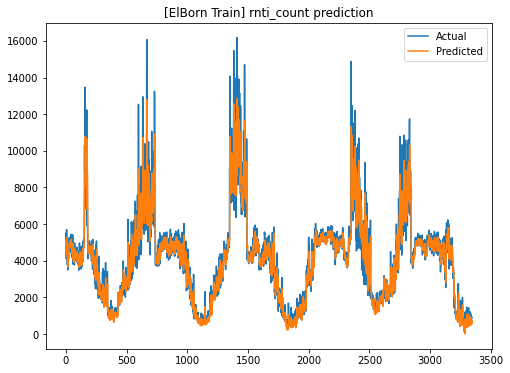

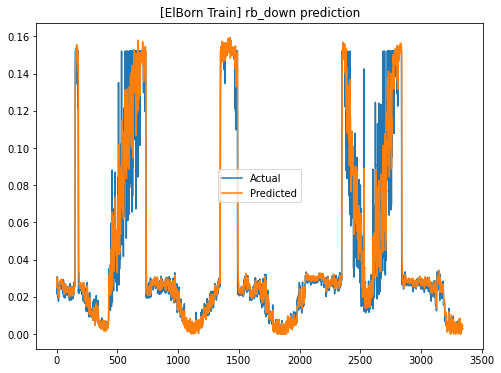

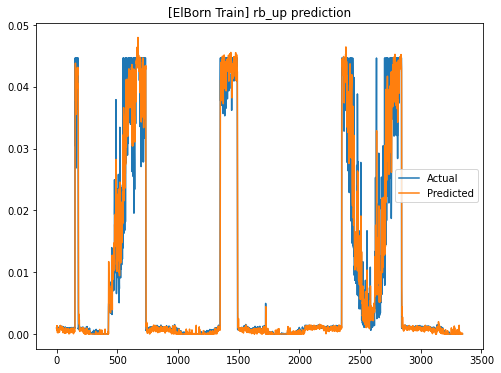

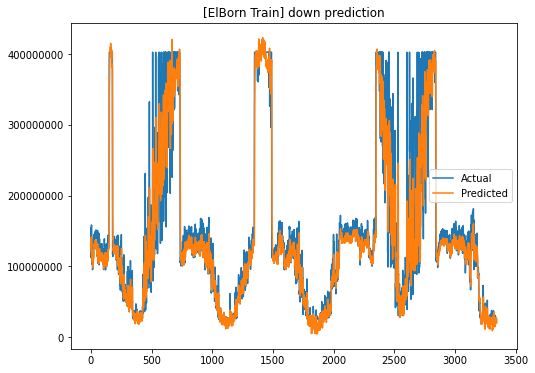

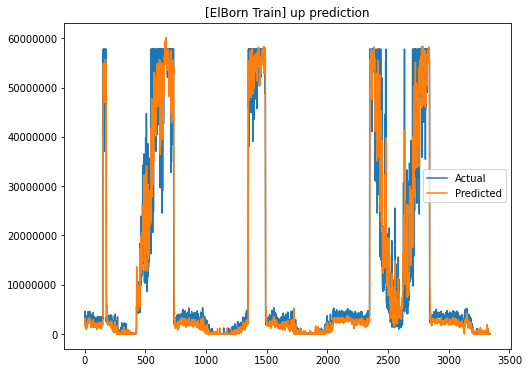

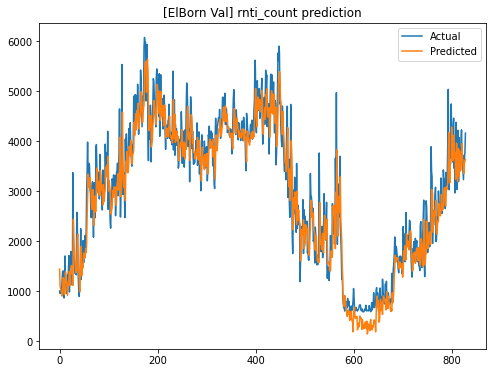

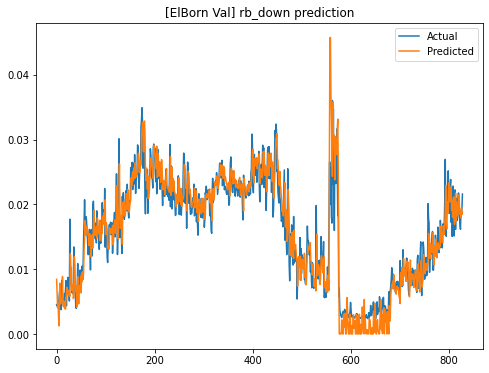

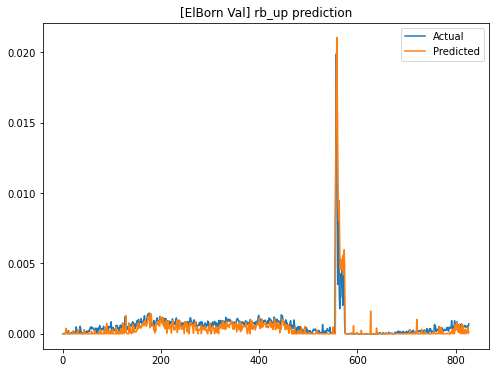

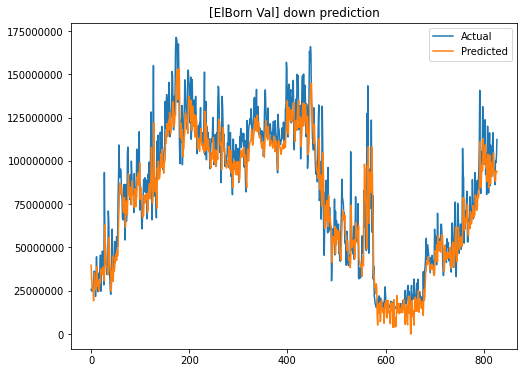

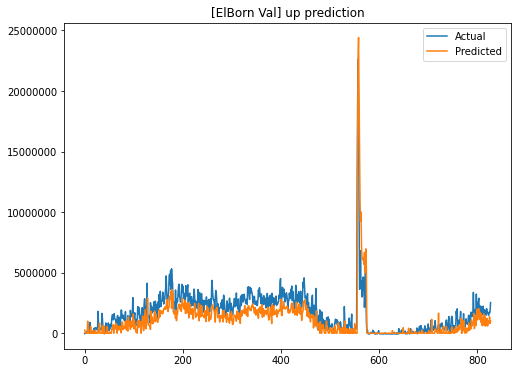

INFO logger 2022-10-25 11:24:15,483 | helpers.py:60 | Metrics for dimension: 0
	mse: 533421.9375, rmse: 730.3574039468622, mae: 543.4523315429688, r^2: 0.8856131793355554, nrmse: 0.17208258730216244
INFO logger 2022-10-25 11:24:15,484 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.00034464214695617557, rmse: 0.018564540041600158, mae: 0.0135037275031209, r^2: 0.8464588527637922, nrmse: 0.24309644086281848
INFO logger 2022-10-25 11:24:15,488 | helpers.py:60 | Metrics for dimension: 2
	mse: 3.0246053938753903e-05, rmse: 0.00549964125545966, mae: 0.003297701245173812, r^2: 0.8747383846561133, nrmse: 0.5191655744166903
INFO logger 2022-10-25 11:24:15,491 | helpers.py:60 | Metrics for dimension: 3
	mse: 2212030027137024.0, rmse: 47032223.28507365, mae: 35315152.0, r^2: 0.8641143785222165, nrmse: 0.2504612533992192
INFO logger 2022-10-25 11:24:15,494 | helpers.py:60 | Metrics for dimension: 4
	mse: 51003525169152.0, rmse: 7141675.235485859, mae: 4591715.0, r^2: 0.8719053532677201, nrmse:


Final Prediction on LesCorts (Inference Stage)
[Train]: mse: 452607411748864.0, rmse: 21274571.95218893, mae 7981461.0, r2: 0.8685660297090795, nrmse: 0.37422682985732136
[Val]: mse: 768371528302592.0, rmse: 27719515.297035623, mae 9677558.0, r2: -3.7666065157581, nrmse: 1.286162915013814




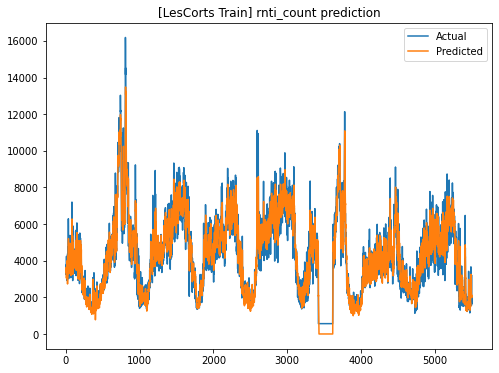

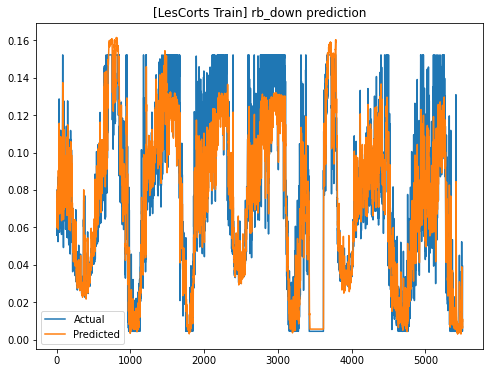

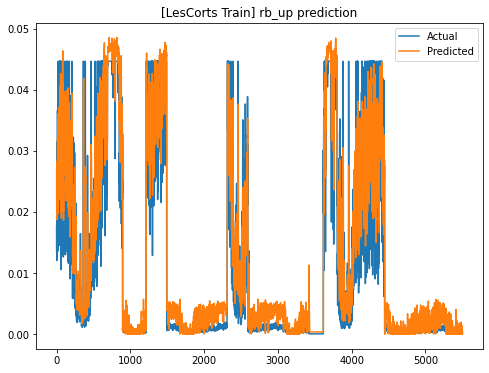

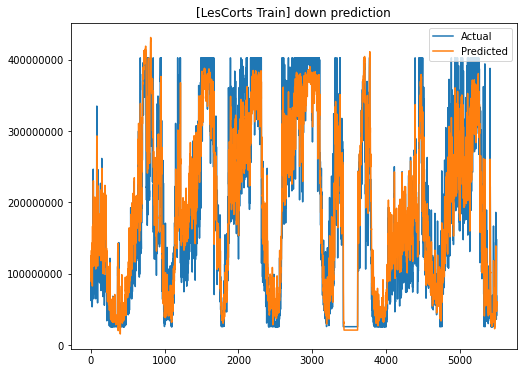

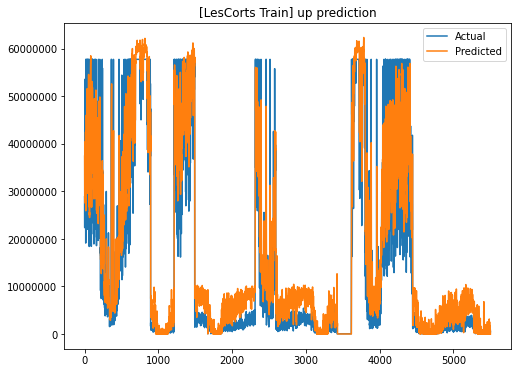

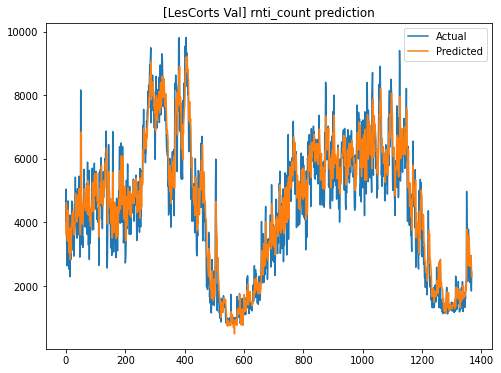

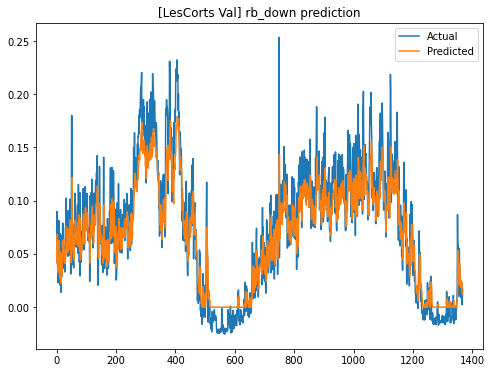

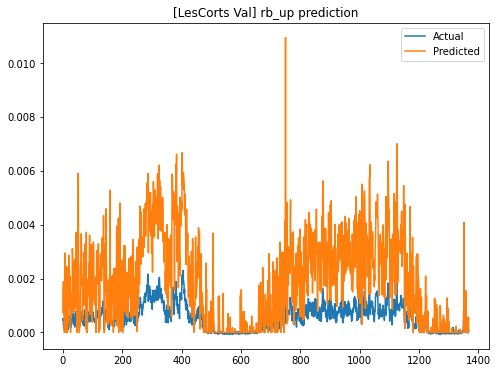

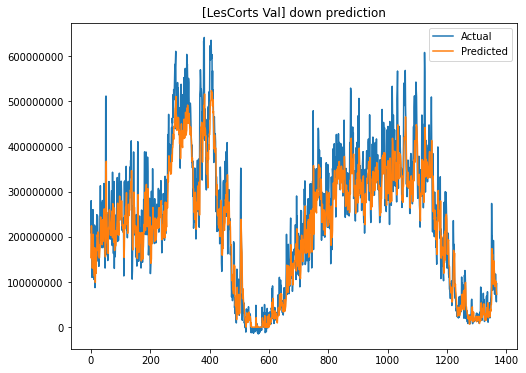

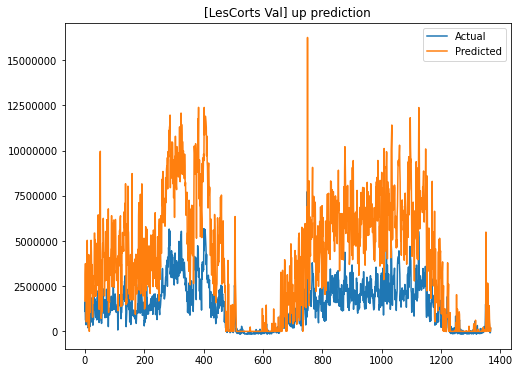

INFO logger 2022-10-25 11:24:16,808 | helpers.py:60 | Metrics for dimension: 0
	mse: 1411184.875, rmse: 1187.933026310827, mae: 829.3123779296875, r^2: 0.7621508216526331, nrmse: 0.21755079330904725
INFO logger 2022-10-25 11:24:16,811 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.00027288077399134636, rmse: 0.016519103304699877, mae: 0.00904309656471014, r^2: 0.8362413930455448, nrmse: 0.4773312230957124
INFO logger 2022-10-25 11:24:16,813 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.1508396457647905e-05, rmse: 0.004637714572679943, mae: 0.0020351079292595387, r^2: 0.8918908022124035, nrmse: 0.6181226693467714
INFO logger 2022-10-25 11:24:16,814 | helpers.py:60 | Metrics for dimension: 3
	mse: 2182686005264384.0, rmse: 46719225.22114835, mae: 30524234.0, r^2: 0.7744415866444971, nrmse: 0.36434595775435535
INFO logger 2022-10-25 11:24:16,816 | helpers.py:60 | Metrics for dimension: 4
	mse: 37010500747264.0, rmse: 6083625.625173199, mae: 2676958.0, r^2: 0.8829179390190085, nrm


Final Prediction on PobleSec (Inference Stage)
[Train]: mse: 443939127558144.0, rmse: 21069863.017071184, mae 6640402.5, r2: 0.8295285085148173, nrmse: 0.49035286331847505
[Val]: mse: 826546457673728.0, rmse: 28749721.001667615, mae 8135873.5, r2: 0.6258148138148588, nrmse: 1.209475811304244




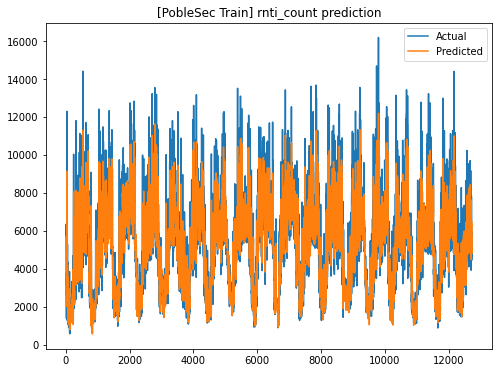

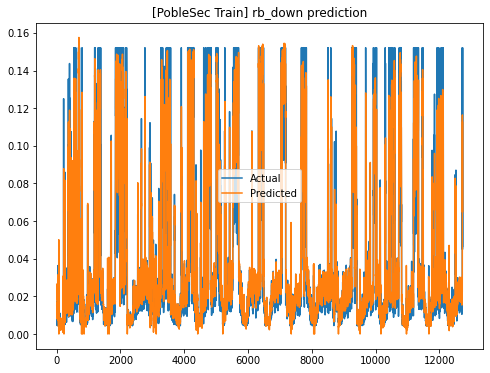

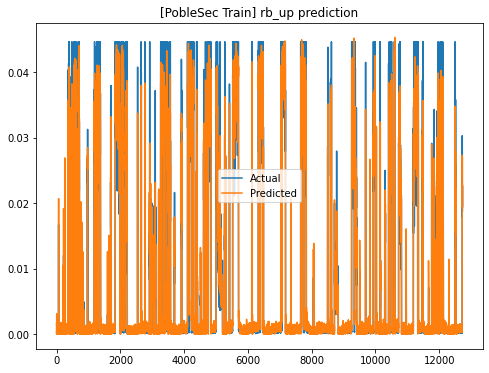

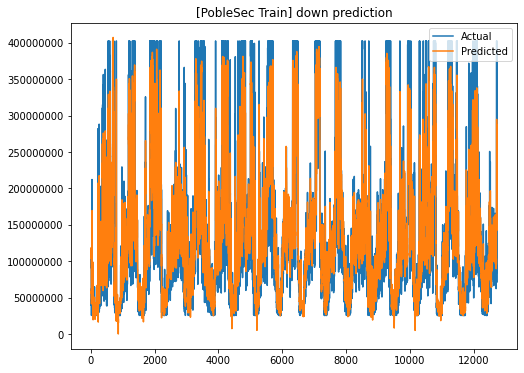

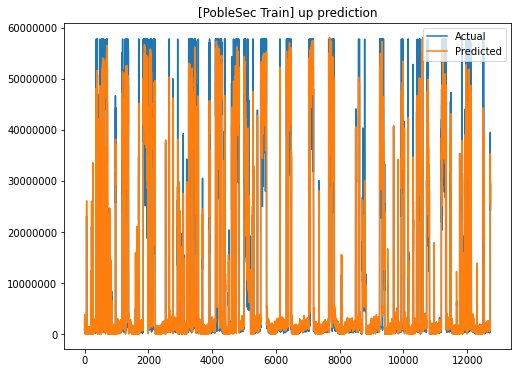

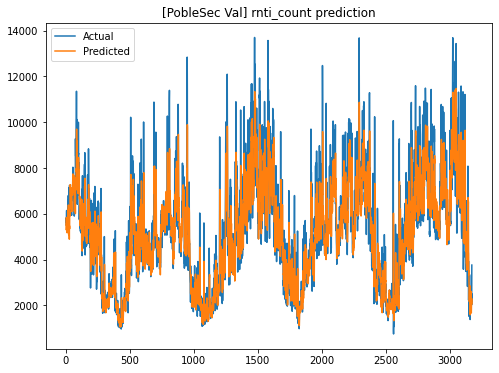

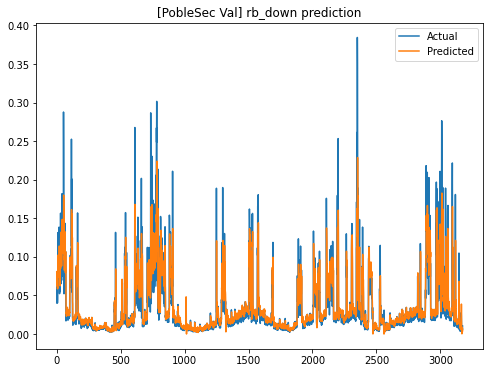

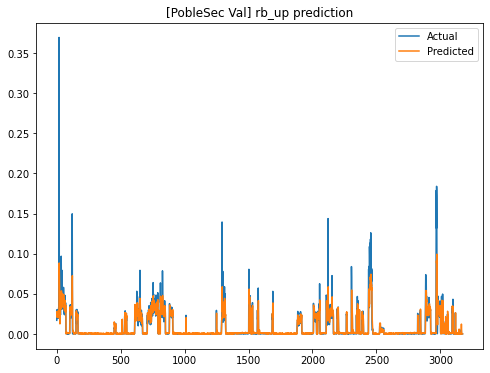

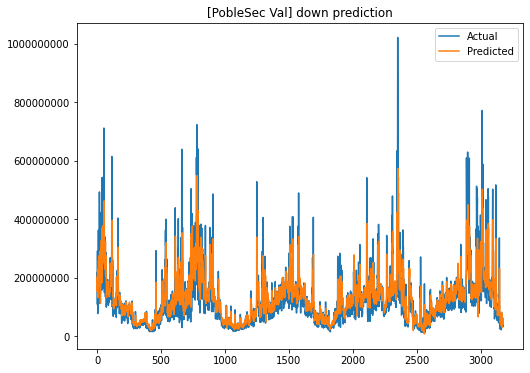

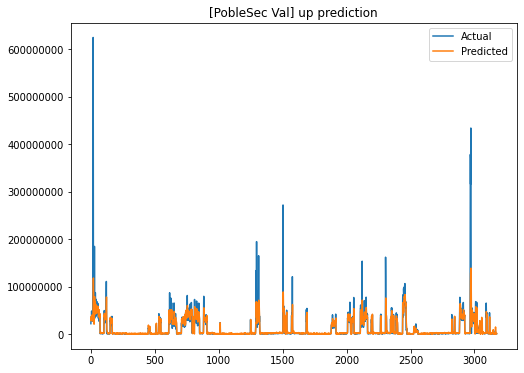

In [30]:
inference(
    global_model,
    client_X_train, 
    client_y_train,
    client_X_val, 
    client_y_val,
    exogenous_data_train, 
    exogenous_data_val,
    y_scalers
)